In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import os
import glob
import math
import time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [2]:
""" 
   0           1            2             3               4         5       6       7     
bdev	     IO type	Submit ts	Complete ts	    bdev_latency	qd	    Size	Offset
"""
trace_path = f'./bdev_log.txt'
record = {'action':[], 'Dt':[], 'Ct':[], 'sector':[], 'bytes':[], 'd2c':[], 'device':[]}
cnt = 0
with open(trace_path, 'r') as f:
    line = next(f)
    print(line)
    while True:
        try:
            line = next(f)
        except:
            print('finish')
            break
        line = line.split()
        device = str(line[0])
        action = int(line[1]);
        Dt = float(line[2]); Ct = float(line[3])
        d2c = float(line[4]); bytes = int(line[6])
        sector = int(line[7]); 
        record['action'].append(action); record['Dt'].append(Dt); record['Ct'].append(Ct)
        record['sector'].append(sector); record['bytes'].append(bytes); record['d2c'].append(d2c); record['device'].append(device)
        cnt += 1
        if cnt % 100000 == 0:
            print(cnt)

bdev	IO type	Submit ts	Complete ts	bdev_latency	qd	Size	Offset

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
finish


In [3]:
Action = np.array(record['action'], dtype=int)
DT = (np.array(record['Dt'])-record['Dt'][0])/(10**3) # in ms
CT = (np.array(record['Ct'])-record['Ct'][0])/(10**3) # in ms
Sector = np.array(record['sector'], dtype=int)
Bytes = np.array(record['bytes'], dtype=int) # 每个逻辑单位代表4KB
D2C = np.array(record['d2c'])

In [4]:
size_num, size_u = np.unique(Action, return_counts=True)
size_num, size_u

(array([1, 2]), array([1272865, 1271691]))

[ 4096  8192 32768] [      6 2544547       3]
[132.9  158.21 175.76 199.33 244.96 266.44]
[   6.      6.04    6.05 ... 1693.06 1695.32 1733.2 ]
[210.53 275.78 279.64]
[   6.86    6.87    6.88 ... 3831.3  3846.74 4128.99]
IO latency cdf figure


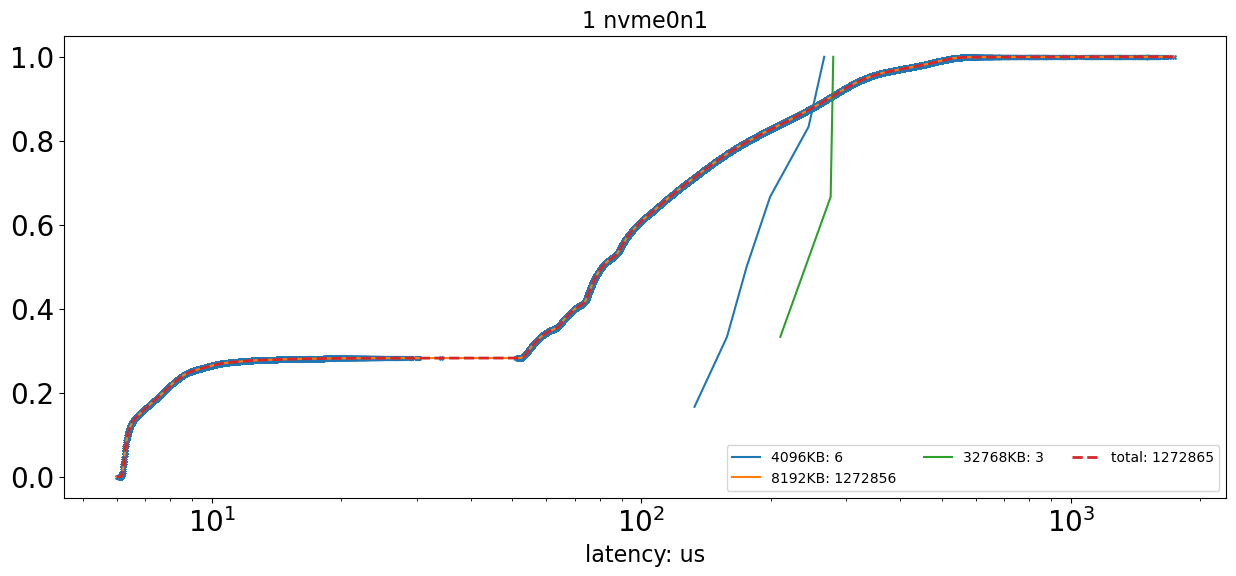

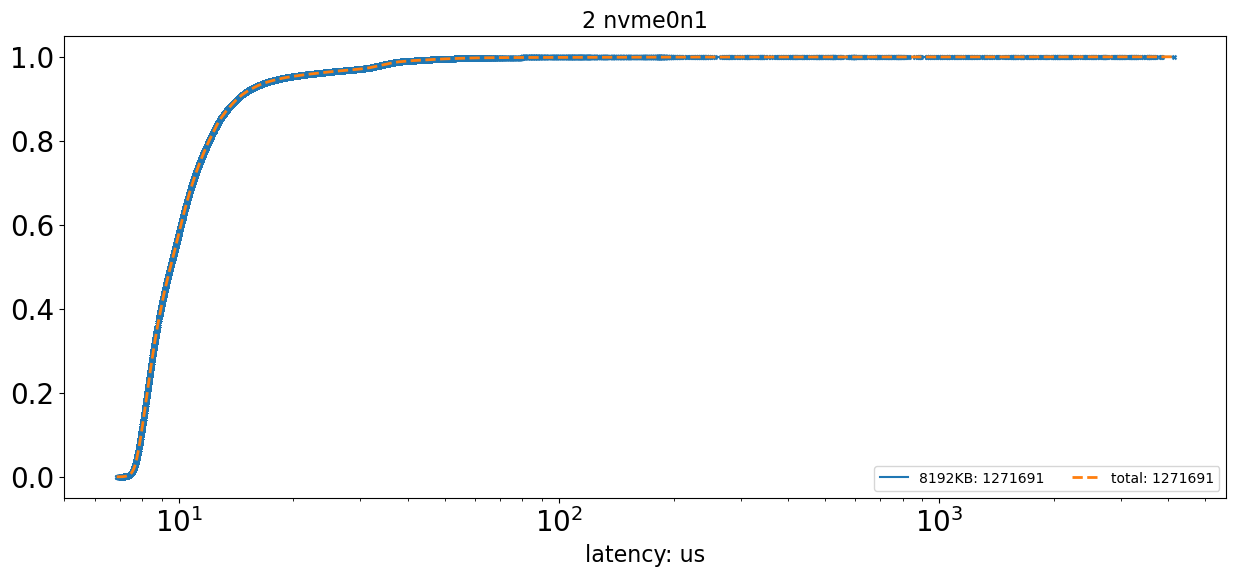

In [10]:
size_num, size_u = np.unique(Bytes, return_counts=True)
print(size_num, size_u)
size_dict = {1:{}, 2:{}} # 1 表示 read, 2 表示 write
for i in size_num:
    size_dict[1][i] = []
    size_dict[2][i] = []
d2clat = D2C
for idx, s in enumerate(Bytes):
    if Action[idx] == 1:
        size_dict[1][s].append(d2clat[idx])
    else:
        size_dict[2][s].append(d2clat[idx])
for (type, value) in size_dict.items():
    fig3, ax3 = plt.subplots(figsize=(15,6))
    ax3.set_title(f"{type} {device}", fontdict={'size':16})
    for (k, v) in value.items():
        if math.log2(k).is_integer() and len(v) != 0:
            latency = np.sort(v)
            print(latency)
            ecdf = sm.distributions.ECDF(latency)
            xs = latency
            ys = ecdf(xs)
            draw_range = np.where(ys >= 0)[0]
            ys = ys[draw_range]
            xs = xs[draw_range]
            # ax3.set_xlim((0, 3000))
            ax3.set_xlabel("latency: us", fontdict={'size':16})
            # ax3.set_xscale('log')
            ax3.plot(xs, ys, label=f"{k}KB: {len(v)}")
            ax3.tick_params(labelsize = 20)
    total_latency = D2C[np.where(Action == type)[0]]
    if len(total_latency) > 0:
        total_latency = np.sort(total_latency)
        ecdf = sm.distributions.ECDF(total_latency)
        xs = total_latency
        ys = ecdf(xs)
        draw_range = np.where(ys >= 0)[0]
        ys = ys[draw_range]
        xs = xs[draw_range]
        ax3.plot(xs, ys, label=f"total: {len(total_latency)}", linestyle='dashed', linewidth=2)
        ax3.scatter(xs, ys, marker='x', s=8)
    ax3.set_xscale('log')
    ax3.legend(ncol=3, loc='lower right', fontsize=10)
print(f"IO latency cdf figure")

2544555


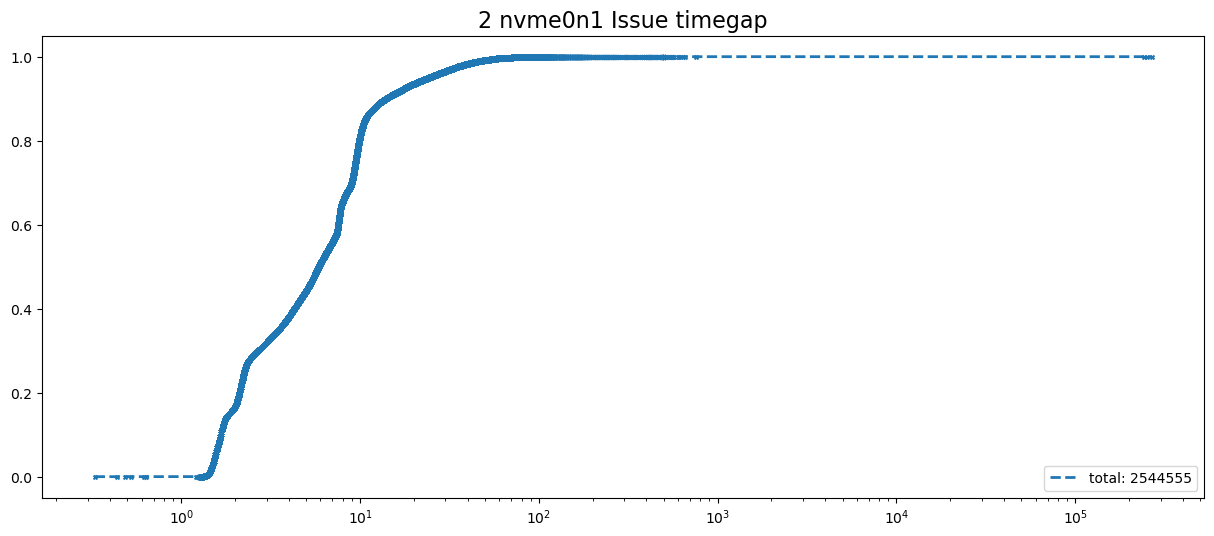

In [35]:
DT = np.sort(np.array(record['Dt']))-np.sort(np.array(record['Dt']))[0] # us
DT_diff = np.diff(DT)
# plt.hist(DT_diff, bins=30, alpha=0.7, color='blue', edgecolor='black')
print(len(DT_diff))
fig2, ax2 = plt.subplots(figsize=(15,6))
ax2.set_title(f"{type} {device} Issue timegap", fontdict={'size':16})
DT_diff = np.sort(DT_diff)
ecdf = sm.distributions.ECDF(DT_diff)
xs = DT_diff
ys = ecdf(xs)
draw_range = np.where(ys >= 0)[0]
ys = ys[draw_range]
xs = xs[draw_range]
ax2.plot(xs, ys, label=f"total: {len(DT_diff)}", linestyle='dashed', linewidth=2)
ax2.scatter(xs, ys, marker='x', s=8)
ax2.legend(ncol=3, loc='lower right', fontsize=10)
ax2.set_xscale('log')

2544555


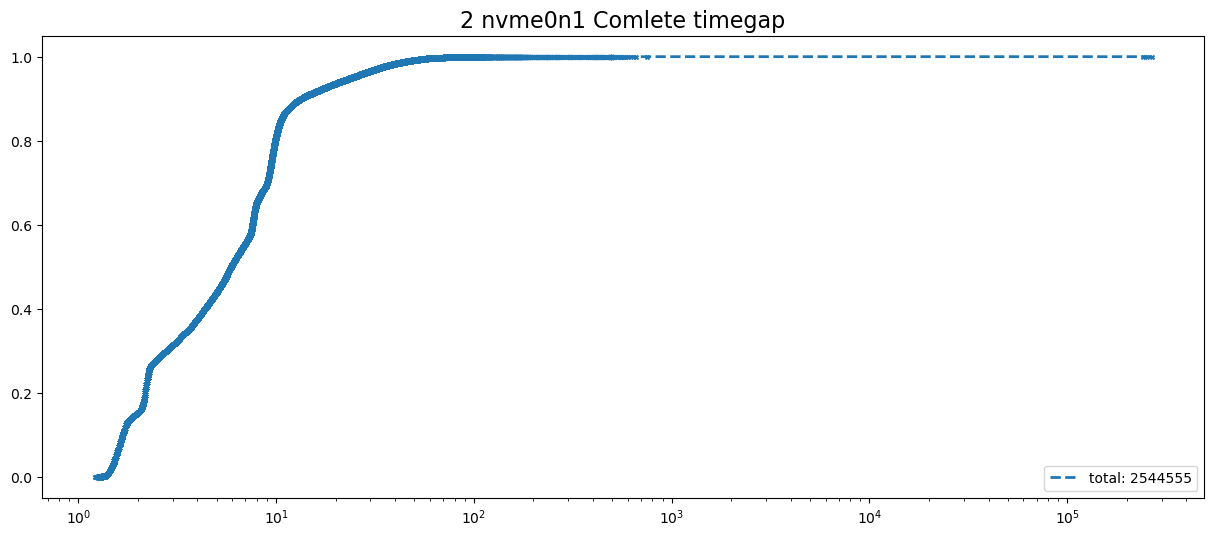

In [36]:
CT = np.sort(np.array(record['Ct']))-np.sort(np.array(record['Ct']))[0] # us
CT_diff = np.diff(CT) # us
# plt.hist(DT_diff, bins=30, alpha=0.7, color='blue', edgecolor='black')
print(len(CT_diff))
fig2, ax2 = plt.subplots(figsize=(15,6))
ax2.set_title(f"{type} {device} Comlete timegap", fontdict={'size':16})
CT_diff = np.sort(CT_diff)
ecdf = sm.distributions.ECDF(CT_diff)
xs = CT_diff
ys = ecdf(xs)
draw_range = np.where(ys >= 0)[0]
ys = ys[draw_range]
xs = xs[draw_range]
ax2.plot(xs, ys, label=f"total: {len(CT_diff)}", linestyle='dashed', linewidth=2)
ax2.scatter(xs, ys, marker='x', s=8)
ax2.legend(ncol=3, loc='lower right', fontsize=10)
ax2.set_xscale('log')

In [39]:
from tqdm import tqdm
merged = np.column_stack((Action, DT+np.sort(np.array(record['Dt']))[0], CT+np.sort(np.array(record['Ct']))[0], D2C, Sector, Bytes))
trace_sortby_dt = merged[np.argsort(DT)]
trace_sortby_ct = merged[np.argsort(CT)]
new_merged = []
dt_cur = 0
ct_cur = 0
dt_cur_ts = trace_sortby_dt[dt_cur][1]
ct_cur_ts = trace_sortby_ct[ct_cur][2]
qd_list = []
qd = 0
hash_table = {}
progress_bar = tqdm(total=len(trace_sortby_dt))
while(dt_cur < len(trace_sortby_dt) and ct_cur < len(trace_sortby_ct)):
    dt_cur_ts = trace_sortby_dt[dt_cur][1]
    ct_cur_ts = trace_sortby_ct[ct_cur][2]
    while(dt_cur_ts < ct_cur_ts and dt_cur < len(trace_sortby_dt)):
        hash_table[tuple(trace_sortby_dt[dt_cur].tolist())] = qd
        new_merged.append(['S']+trace_sortby_dt[dt_cur].tolist()+[qd])
        qd += 1
        qd_list.append(qd)
        dt_cur += 1
        progress_bar.update(1)
        if dt_cur < len(trace_sortby_dt):
            dt_cur_ts = trace_sortby_dt[dt_cur][1]
    if tuple(trace_sortby_ct[ct_cur].tolist()) in hash_table:
        qd -= 1
        qd_list.append(qd)
        new_merged.append(['C']+trace_sortby_ct[ct_cur].tolist()+[qd])
        del hash_table[tuple(trace_sortby_ct[ct_cur].tolist())]
    ct_cur += 1
    # print(dt_cur_ts, ct_cur_ts)
    

100%|█████████▉| 2535965/2544556 [00:25<00:00, 209730.72it/s]

In [40]:
qd_num, qd_u = np.unique(np.array(new_merged)[:, -1], return_counts=True)
print(qd_num, qd_u)

100%|██████████| 2544556/2544556 [00:48<00:00, 209730.72it/s]

['0' '1' '2' '3' '4' '5' '6' '7'] [      7       7       7       1       1       1       1 5089080]
